# Day 1: Gaussian Noise Basics - Interactive Exploration

This notebook provides an interactive sandbox for exploring Gaussian noise effects on images.

## Learning Objectives
- Understand how Gaussian noise affects image quality
- Visualize the relationship between noise level (σ) and image degradation
- Explore different noise schedules
- Analyze pixel distribution changes under noise


In [2]:
# Setup and imports
import sys
import os
sys.path.append('..')

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Import our modules
from src.utils import set_seed, get_device
from src.dataset import get_mnist_loader, get_sample_batch, denormalize_tensor
from src.noise import add_gaussian_noise, sigma_schedule, NoiseScheduler
from src.metrics import noise_degradation_metrics
from src.visualize import make_progressive_grid

# Setup
set_seed(42)
device = get_device()

print(f"Using device: {device}")
print("🎯 Ready for exploration!")


Using device: cpu
Using device: cpu
🎯 Ready for exploration!


## 1. Load and Visualize Clean Data

Let's start by loading MNIST data and examining clean images before adding noise.


Created MNIST train DataLoader:
  - Dataset size: 60000
  - Batch size: 64
  - Number of batches: 937
  - Normalization range: (0, 1)


/Users/christianlin/miniconda3/envs/generative/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch shape: torch.Size([64, 1, 28, 28])
Value range: [0.000, 1.000]


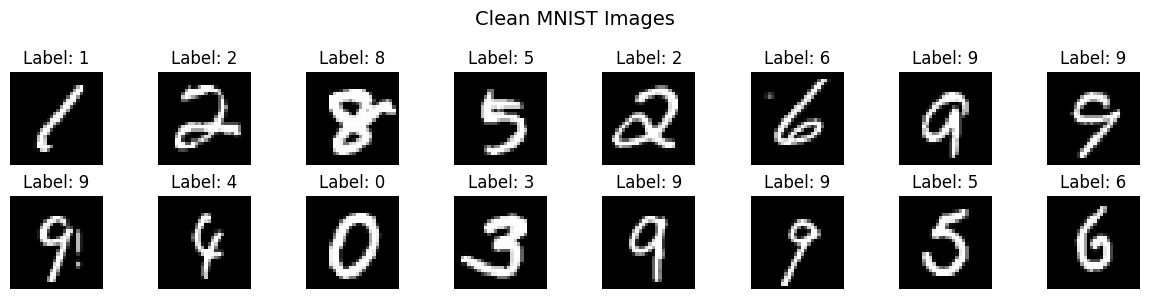

In [3]:
# Load MNIST data
dataloader = get_mnist_loader(
    root="../data", 
    split="train", 
    batch_size=64,
    normalize_range=(0, 1)
)

# Get a sample batch
images, labels = get_sample_batch(dataloader, device)
print(f"Batch shape: {images.shape}")
print(f"Value range: [{images.min():.3f}, {images.max():.3f}]")

# Display first few images
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i in range(16):
    row, col = i // 8, i % 8
    img = images[i].cpu().squeeze()
    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].set_title(f'Label: {labels[i].item()}')
    axes[row, col].axis('off')

plt.suptitle('Clean MNIST Images', fontsize=14)
plt.tight_layout()
plt.show()


## 2. Interactive Noise Exploration

Try adjusting the sigma parameter below to see how different noise levels affect image quality!


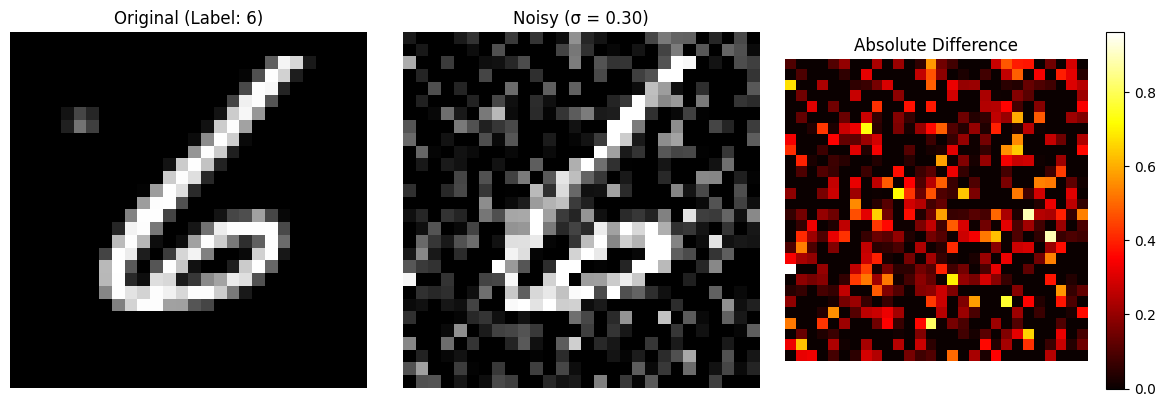


📊 Metrics for σ = 0.30:
  SNR: 10.46 dB
  PSNR: 13.50 dB
  SSIM: 0.5217
  MSE: 0.044654


In [ ]:
# Interactive function to explore different noise levels
def explore_noise_level(sigma=0.3, image_idx=0, seed=42):
    """
    Interactive function to explore noise effects.
    Adjust sigma and image_idx to see different results.
    """
    set_seed(seed)
    generator = torch.Generator(device=device).manual_seed(seed)
    
    # Get image
    selected_img = images[image_idx:image_idx+1]
    original_label = labels[image_idx].item()
    
    # Add noise
    noisy_img = add_gaussian_noise(selected_img, sigma, clip_range=(0, 1), generator=generator)
    
    # Compute metrics
    metrics = noise_degradation_metrics(selected_img, sigma, noisy_img, max_val=1.0)
    
    # Display
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    # Original
    axes[0].imshow(selected_img.cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
    axes[0].set_title(f'Original (Label: {original_label})')
    axes[0].axis('off')
    
    # Noisy
    axes[1].imshow(noisy_img.cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
    axes[1].set_title(f'Noisy (σ = {sigma:.2f})')
    axes[1].axis('off')
    
    # Difference
    diff = torch.abs(selected_img - noisy_img).cpu().squeeze()
    im = axes[2].imshow(diff, cmap='hot', vmin=0, vmax=diff.max())
    axes[2].set_title('Absolute Difference')
    axes[2].axis('off')
    plt.colorbar(im, ax=axes[2], shrink=0.8)
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print(f"\n📊 Metrics for σ = {sigma:.2f}:")
    print(f"  SNR: {metrics['snr_db']:.2f} dB")
    print(f"  PSNR: {metrics['psnr']:.2f} dB")
    print(f"  SSIM: {metrics['ssim']:.4f}")
    print(f"  MSE: {metrics['mse']:.6f}")

# Try different values! Change these parameters:
explore_noise_level(sigma=0.3, image_idx=5, seed=123)


## Key Insights and Next Steps

Based on your experiments, you should observe:

1. **Progressive Degradation**: As σ increases, image quality decreases monotonically
2. **SNR Relationship**: SNR (dB) = 10 * log₁₀(1 / σ²) for unit variance data
3. **Metrics Behavior**: PSNR decreases, SSIM approaches 0, MSE increases with noise

### Next Steps

1. Run the CLI commands to generate full datasets:
   ```bash
   cd ..  # Go back to project root
   python -m src.cli add-noise --config configs/default.yaml
   python -m src.cli animate --config configs/default.yaml
   ```

2. Experiment with different noise schedules in the config file
3. Try different values in the `explore_noise_level` function above
4. Move on to Day 2: Denoising Autoencoder!
